# 1. Setup and get data

### 1.1 Install dependencies and setup

In [1]:
%pip install labelme tensorflow opencv-python matplotlib albumentations

Note: you may need to restart the kernel to use updated packages.


### 1.2 Collect images using OpenCv

In [1]:
import os
import time
import uuid
import cv2

In [2]:
DATA_PATH = '../data'
AUG_PATH = '../aug_data'
IMAGES_PATH = os.path.join(DATA_PATH, 'images')
number_images = 30

In [4]:
cap = cv2.VideoCapture(0)
for img_num in range(number_images):
    print(f'Collecting image #{img_num}')
    ret, frame = cap.read()
    img_name = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(img_name, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()
cv2.waitKey(1)
cap.release()

OUT OF LOOP


### 1.3 Annotate images with LabelMe

In [6]:
!labelme

[INFO   ] __init__:get_config:70 - Loading config file from: /Users/tomasmonaco/.labelmerc
2023-08-09 19:49:14.041 Python[91520:1587021] +[CATransaction synchronize] called within transaction
2023-08-09 19:49:28.835 Python[91520:1587021] +[CATransaction synchronize] called within transaction


# 2. Review dataset and build image loading fn

### 2.1 Import needed dependencies

In [3]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

2023-08-14 09:37:00.786365: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 2.2 Load images into TF data pipeline

In [5]:
images = tf.data.Dataset.list_files('../data/images/*.jpg', shuffle=False)

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: ../data/images/*.jpg'

In [4]:
def load_image(img_path):
    byte_img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [ ]:
images = images.map(load_image)

In [ ]:
images.as_numpy_iterator().next()

array([[[54, 53, 33],
        [57, 56, 36],
        [57, 54, 37],
        ...,
        [85, 86, 78],
        [88, 90, 79],
        [87, 89, 78]],

       [[71, 70, 50],
        [57, 56, 36],
        [62, 59, 42],
        ...,
        [85, 86, 78],
        [84, 86, 75],
        [89, 91, 80]],

       [[64, 63, 45],
        [61, 60, 42],
        [67, 64, 49],
        ...,
        [88, 89, 81],
        [90, 91, 83],
        [87, 88, 80]],

       ...,

       [[70, 65, 35],
        [65, 61, 32],
        [67, 61, 35],
        ...,
        [70, 79, 74],
        [73, 79, 75],
        [71, 78, 71]],

       [[71, 64, 36],
        [62, 57, 28],
        [67, 60, 34],
        ...,
        [74, 85, 77],
        [69, 79, 71],
        [79, 89, 80]],

       [[68, 61, 33],
        [68, 61, 33],
        [68, 60, 37],
        ...,
        [63, 76, 67],
        [67, 77, 68],
        [68, 78, 69]]], dtype=uint8)

### 2.3 View raw images with matplotlib

In [ ]:
image_generator = images.batch(5).as_numpy_iterator()

In [ ]:
plot_images = image_generator.next()

NameError: name 'plot_images' is not defined

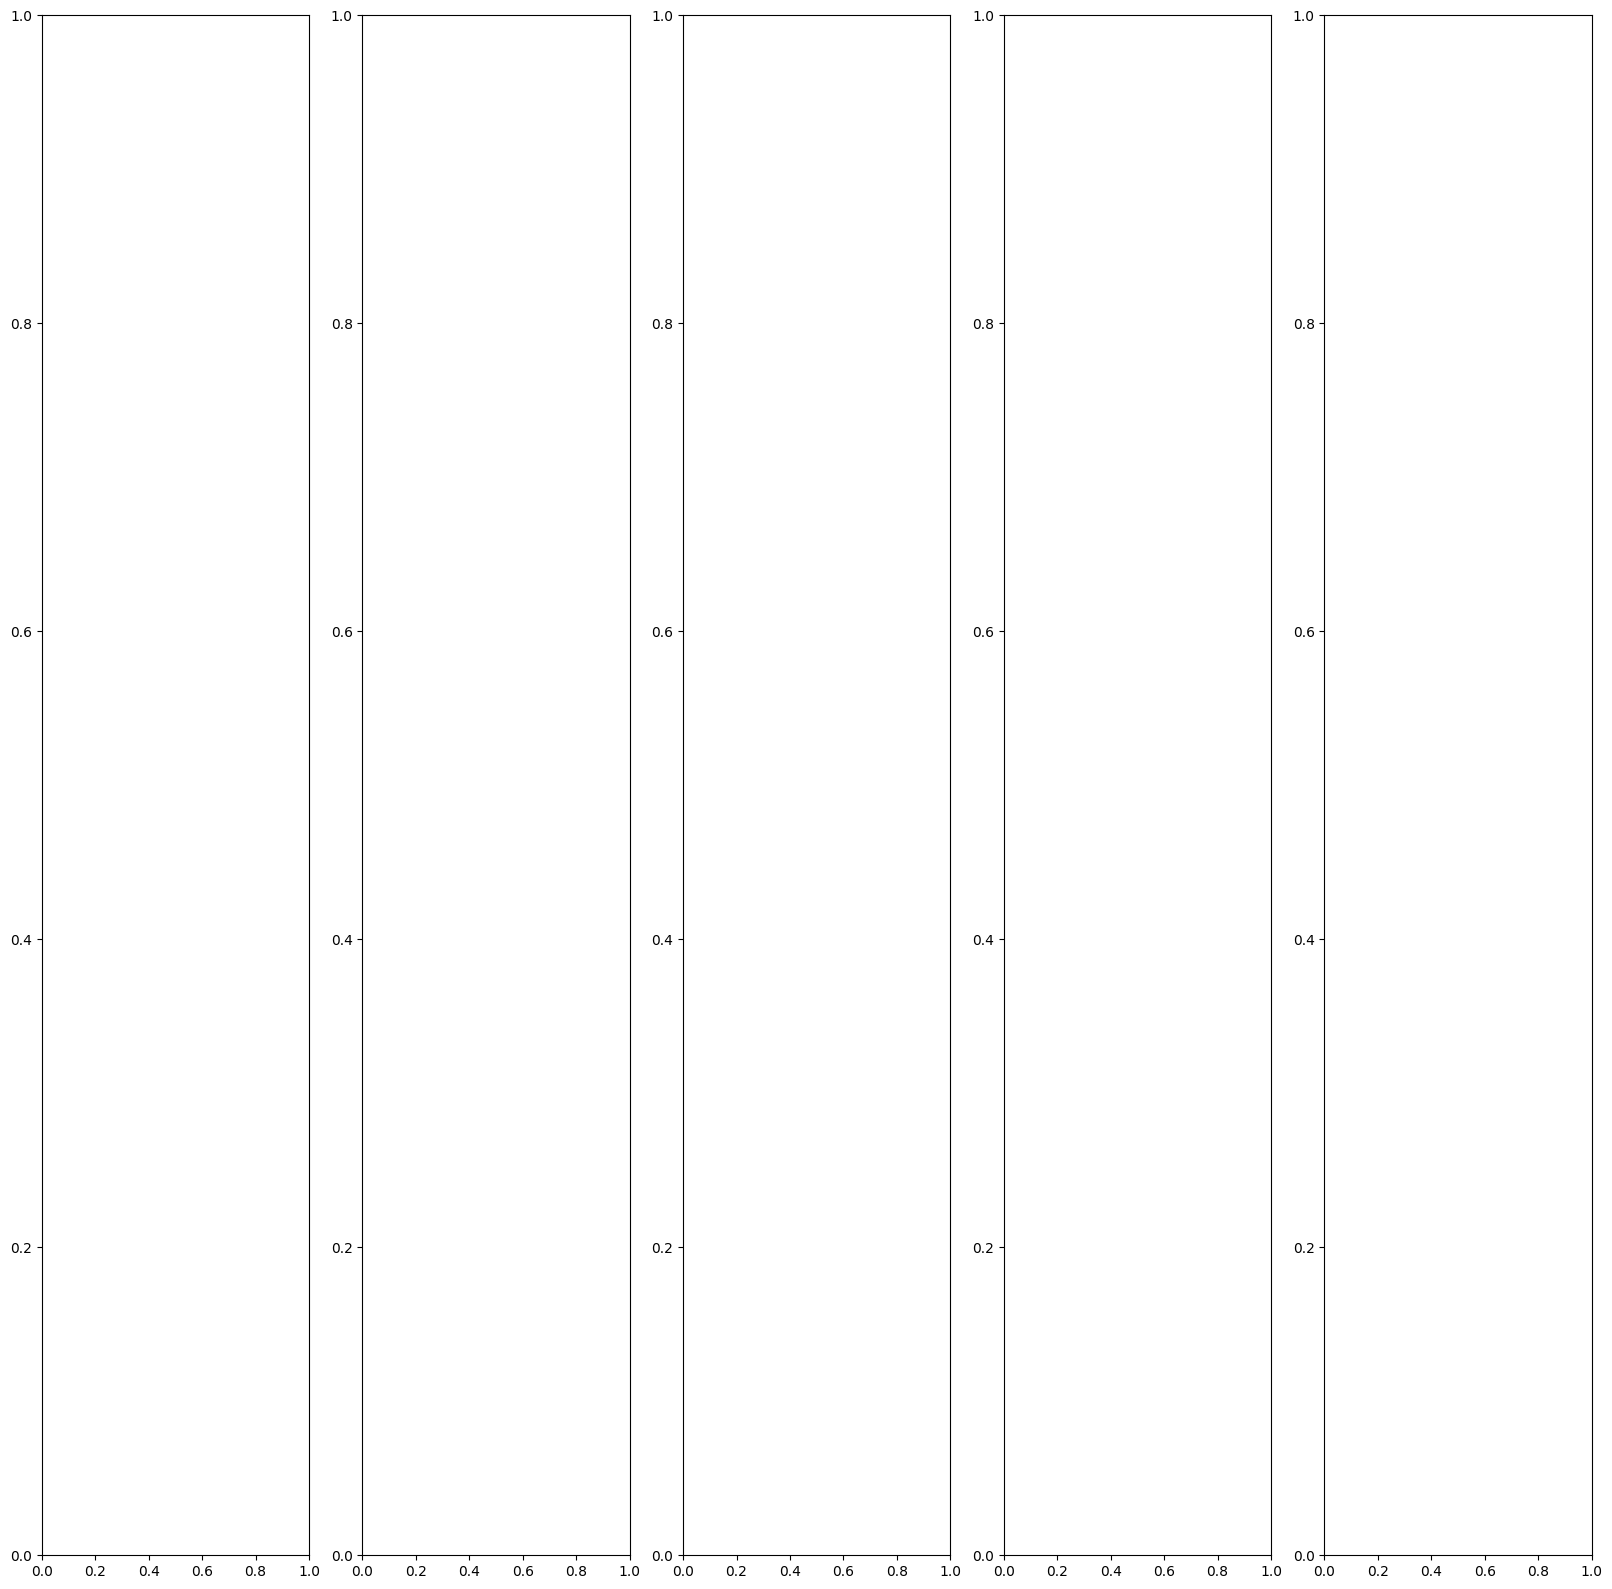

In [6]:
fig, ax = plt.subplots(ncols=5, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show

# 3. Partition augmented data

### 3.1 Manually split data into train/validation/test set - (try test_train from scikitlearn)

In [33]:
60 * .7 # train

42.0

In [32]:
60 * .15 # val

9.0

In [34]:
60 * .15  # test

9.0

### 3.2 Move the matching labels

In [42]:
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join(DATA_PATH, folder, 'images')):
        filename = file.split('.')[0] + '.json'
        existing_file_path = os.path.join(DATA_PATH, 'labels', filename)
        if os.path.exists(existing_file_path):
            new_file_path = os.path.join(DATA_PATH, folder, 'labels', filename)
            os.replace(existing_file_path, new_file_path)

# 4. Apply image augmentation using Albumentations

### 4.1 Setup albumentation's transform pipeline

In [8]:
import albumentations as alb

In [9]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450)
                        ,alb.HorizontalFlip(p=0.5)
                        ,alb.RandomBrightnessContrast(p=0.2)
                        ,alb.RandomGamma(p=0.2)
                        ,alb.RGBShift(p=0.2)
                        ,alb.VerticalFlip(p=0.5)]
                        ,bbox_params=alb.BboxParams(format='albumentations'
                                                     ,label_fields=['class_labels'])
                        )

### 4.2 Load and Test image with OpenCv and Json

In [11]:
img = cv2.imread(os.path.join(DATA_PATH, 'train', 'images', '8b2fe02a-36dc-11ee-9697-38f9d330045e.jpg'))

In [12]:
with open(os.path.join(DATA_PATH, 'train', 'labels', '8b2fe02a-36dc-11ee-9697-38f9d330045e.json'), 'r') as f:
    label = json.load(f)

In [13]:
img.shape

(720, 1280, 3)

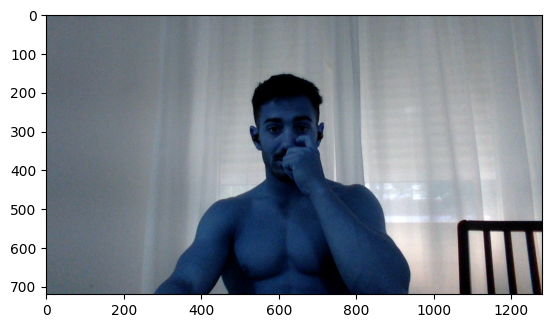

In [14]:
plt.imshow(img)

### 4.3 Extract coordinates and rescale to match new resolution

In [15]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [16]:
coords

[509.10112359550567, 144.83146067415726, 749.5505617977528, 457.19101123595505]

In [17]:
coords = list(np.divide(coords, [1280, 720, 1280, 720]))

In [18]:
coords

[0.3977352528089888,
 0.20115480649188508,
 0.5855863764044944,
 0.6349875156054932]

### 4.4 Apply augmentation and view results

In [19]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [20]:
augmented['bboxes']

[(0.023220973782771437,
  0.13068664169787758,
  0.5575530586766541,
  0.8248189762796505)]

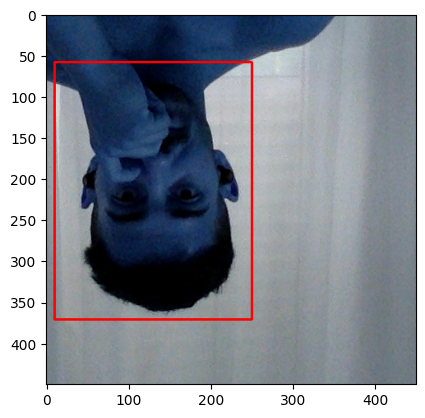

In [21]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [450, 450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450, 450]).astype(int)),
              (255, 0, 0),
              2
              )
plt.imshow(augmented['image'])

# 5. Build and run Augmentation pipeline

### 5.1 Run augmentation pipeline

In [39]:
for partition in ['train', 'val', 'test']:
    for image in os.listdir(os.path.join(DATA_PATH, partition, 'images')):
        image_filename = image.split(".")[0]
        img = cv2.imread(os.path.join(DATA_PATH, partition, 'images', image))

        coords = [0, 0, 0.00001, 0.00001]
        label_path = os.path.join(DATA_PATH, partition, 'labels', f'{image_filename}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
            
            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]

            coords = list(np.divide(coords, [1280, 720, 1280, 720]))

        try:
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join(AUG_PATH, partition, 'images', f'{image_filename}{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0

                with open(os.path.join(AUG_PATH, partition, 'labels', f'{image_filename}{x}.json'),  'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(f'--- EXCEPTION {image} --- \n{e}')

--- EXCEPTION c43675ec-36db-11ee-9f30-38f9d330045e.jpg --- 
x_max is less than or equal to x_min for bbox [0.6013869382022472, 0.9658239700374532, 0.362622893258427, 0.4118289637952559, 'face'].
--- EXCEPTION 8e753320-36dc-11ee-9697-38f9d330045e.jpg --- 
x_max is less than or equal to x_min for bbox [0.5838307584269663, 0.5959737827715355, 0.4135358146067416, 0.20583645443196003, 'face'].
--- EXCEPTION c68d3f92-36db-11ee-9f30-38f9d330045e.jpg --- 
x_max is less than or equal to x_min for bbox [0.6479108146067416, 0.7457865168539327, 0.3722787921348315, 0.1949126092384519, 'face'].
--- EXCEPTION 93b5bb98-36dc-11ee-9697-38f9d330045e.jpg --- 
x_max is less than or equal to x_min for bbox [0.3020540730337079, 0.6147003745318351, 0.15721558988764048, 0.2651373283395755, 'face'].
--- EXCEPTION c734fa48-36db-11ee-9f30-38f9d330045e.jpg --- 
x_max is less than or equal to x_min for bbox [0.6382549157303371, 0.7504681647940075, 0.34418890449438205, 0.18398876404494377, 'face'].
--- EXCEPTION 8dc

### 5.2 Load augmented data into tensorflow dataset

In [104]:
train_images = tf.data.Dataset.list_files('../aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x , (120, 120)))
train_images = train_images.map(lambda x: x/255)

In [105]:
val_images = tf.data.Dataset.list_files('../aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x , (120, 120)))
val_images = val_images.map(lambda x: x/255)

In [106]:
test_images = tf.data.Dataset.list_files('../aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x , (120, 120)))
test_images = test_images.map(lambda x: x/255)

# 6. Prepare labels

### 6.1 Build label loading fn

In [107]:
def load_label(label_path):
    with open(label_path.numpy(), 'r', encoding='utf-8') as f :
        label = json.load(f)
    
    return [label['class']], label['bbox']

### 6.2 Load labels to TensorFlow dataset

In [108]:
train_labels = tf.data.Dataset.list_files('../aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x : tf.py_function(load_label, [x], [tf.uint8, tf.float16]))


In [109]:
val_labels = tf.data.Dataset.list_files('../aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x : tf.py_function(load_label, [x], [tf.uint8, tf.float16]))

In [110]:
test_labels = tf.data.Dataset.list_files('../aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x : tf.py_function(load_label, [x], [tf.uint8, tf.float16]))

  # 7. Combine label and image samples

### 7.1 Check partitions length

In [111]:
len(train_images) == len(train_labels), len(val_images) == len(val_labels), len(test_images) == len(test_labels)

(True, True, True)

### 7.2 Create final Dataset

In [112]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(2000)
train = train.batch(8)
train = train.prefetch(4)

In [113]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(2000)
val = val.batch(8)
val = val.prefetch(4)

In [114]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(2000)
test = test.batch(8)
test = test.prefetch(4)

### 7.3 View images and annotations

In [34]:
data_samples = train.as_numpy_iterator()

In [35]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


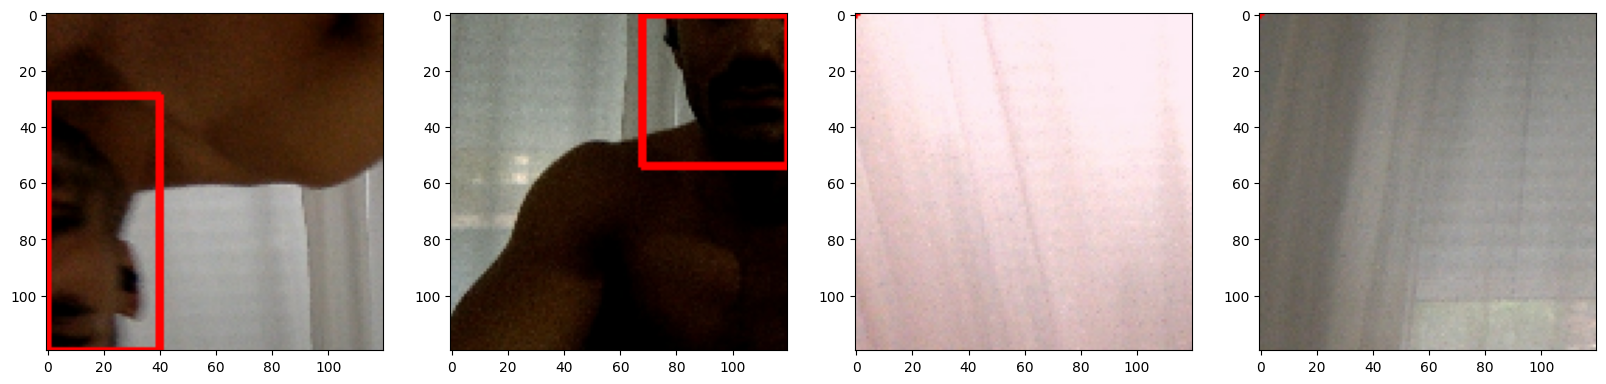

In [36]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image,
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                  (255, 0, 0), 2)
    
    ax[idx].imshow(sample_image)

# 8. Build deep learinig using Funtional API

### 8.1 Import layers and base network

In [37]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, GlobalMaxPooling2D, Dense
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [38]:
vgg = VGG16(include_top=False)

In [39]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Build our base model

In [40]:
def build_model():
    input_layer = Input(shape=(120, 120, 3))
    
    vgg = VGG16(include_top=False)(input_layer)

    f1 = GlobalMaxPooling2D(name='g_max_pooling_class')(vgg)
    class1 = Dense(2048, activation='relu', name='class_first_layer')(f1)
    class2 = Dense(1, activation='sigmoid', name='class_second_layer')(class1)
    
    f2 = GlobalMaxPooling2D(name='g_max_pooling_regress')(vgg)
    regress1 = Dense(2048, activation='relu', name='regress_first_layer')(f2)
    regress2 = Dense(4, activation='sigmoid', name='regress_second_layer')(regress1)
    
    object_detection = Model(inputs=input_layer, outputs=[class2, regress2])
    
    return object_detection

### 8.4 Test NN

In [41]:
facetracker = build_model()

In [42]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 g_max_pooling_class (Globa  (None, 512)                  0         ['vgg16[0][0]']               
 lMaxPooling2D)                                                                                   
                                                                                              

In [43]:
X, y = train.as_numpy_iterator().next()

In [44]:
X.shape

(8, 120, 120, 3)

In [45]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 1s 809ms/step


In [46]:
classes, coords

(array([[0.4191859 ],
        [0.4252772 ],
        [0.3850377 ],
        [0.41032058],
        [0.34225038],
        [0.3984721 ],
        [0.382874  ],
        [0.40550786]], dtype=float32),
 array([[0.33699796, 0.6129714 , 0.5098657 , 0.5324999 ],
        [0.21308668, 0.6365857 , 0.50748956, 0.6252364 ],
        [0.2588832 , 0.5877132 , 0.55730605, 0.62319195],
        [0.20800836, 0.6296458 , 0.5564685 , 0.5563699 ],
        [0.2524347 , 0.57838345, 0.6083323 , 0.51229596],
        [0.2843048 , 0.6129009 , 0.53492475, 0.54164726],
        [0.24647863, 0.6303311 , 0.57937276, 0.6099955 ],
        [0.24238633, 0.65020865, 0.5257997 , 0.5645932 ]], dtype=float32))

# 9. Define Losses and Optimizer

### 9.1 Defien Optimizer and LR

In [49]:
batches_per_epoch = len(train)
# lr_decay = (1./0.75 - 1) / batches_per_epoch
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.9)

In [50]:
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

### 9.2 Create Localization and Classification LOSS

In [51]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
    
    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]
    
    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))
    
    return delta_coord + delta_size

In [52]:
class_loss = tf.keras.losses.BinaryCrossentropy()
regress_loss = localization_loss

### 9.3 Test lose fn

In [53]:
regress_loss(y[1], coords).numpy()

6.5302973

In [54]:
class_loss(y[0], classes).numpy()

0.80185604

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [55]:
class FaceTracker(Model):
    def __init__(self, facetracker, **kwargs):
        super().__init__(**kwargs)
        self.model = facetracker
        
    def compile(self, opt, class_loss, localization_loss, **kwargs):
        super().compile(**kwargs)
        self.c_loss = class_loss
        self.l_loss = localization_loss
        self.opt = opt
        
    def train_step(self, batch, **kwargs):
        X, y = batch
        
        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)
            
            batch_c_loss = self.c_loss(y[0], classes)
            batch_l_loss = self.l_loss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_l_loss + 0.5 * batch_c_loss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
            
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_c_loss, "regress_loss":batch_l_loss}
    
    def test_step(self, batch, **kwargs):
        X, y = batch
        
        classes, coords = self.model(X, training=False)
            
        batch_c_loss = self.c_loss(y[0], classes)
        batch_l_loss = self.l_loss(tf.cast(y[1], tf.float32), coords)

        total_loss = batch_l_loss + 0.5 * batch_c_loss
        
        return {"total_loss":total_loss, "class_loss":batch_c_loss, "regress_loss":batch_l_loss}
    
    def call(self, X, **kwargs):
        return self.model(X, **kwargs)
        

In [56]:
model = FaceTracker(facetracker)

In [57]:
model.compile(opt, class_loss, regress_loss)

### 10.2 Train model

In [58]:
logs_dir = '../logs'

In [59]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logs_dir)

In [61]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
210/210 [==============================] - 517s 2s/step - total_loss: 10.6742 - class_loss: 9.3390 - regress_loss: 6.0047 - val_total_loss: 9.4434 - val_class_loss: 3.8562 - val_regress_loss: 7.5153
Epoch 2/20
210/210 [==============================] - 504s 2s/step - total_loss: 10.6698 - class_loss: 9.3390 - regress_loss: 6.0003 - val_total_loss: 10.0595 - val_class_loss: 7.7125 - val_regress_loss: 6.2032
Epoch 3/20
210/210 [==============================] - 417s 2s/step - total_loss: 10.6652 - class_loss: 9.3390 - regress_loss: 5.9957 - val_total_loss: 11.4467 - val_class_loss: 7.7125 - val_regress_loss: 7.5905
Epoch 4/20
210/210 [==============================] - 719s 3s/step - total_loss: 10.6688 - class_loss: 9.3299 - regress_loss: 6.0038 - val_total_loss: 11.7321 - val_class_loss: 11.5687 - val_regress_loss: 5.9477
Epoch 5/20
210/210 [==============================] - 386s 2s/step - total_loss: 10.6740 - class_loss: 9.3299 - regress_loss: 6.0091 - val_total_loss: 10.45

2023-08-14 11:51:03.884792: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 1220 of 2000
2023-08-14 11:51:06.979280: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


210/210 [==============================] - 855s 4s/step - total_loss: 10.6801 - class_loss: 9.3573 - regress_loss: 6.0014 - val_total_loss: 10.6663 - val_class_loss: 7.7125 - val_regress_loss: 6.8101
Epoch 14/20
210/210 [==============================] - 795s 4s/step - total_loss: 10.6695 - class_loss: 9.3390 - regress_loss: 5.9999 - val_total_loss: 9.9682 - val_class_loss: 7.7125 - val_regress_loss: 6.1119
Epoch 15/20
210/210 [==============================] - 545s 3s/step - total_loss: 10.6748 - class_loss: 9.3299 - regress_loss: 6.0099 - val_total_loss: 10.7222 - val_class_loss: 7.7125 - val_regress_loss: 6.8660
Epoch 16/20
210/210 [==============================] - 502s 2s/step - total_loss: 10.6722 - class_loss: 9.3299 - regress_loss: 6.0072 - val_total_loss: 12.2772 - val_class_loss: 11.5687 - val_regress_loss: 6.4929
Epoch 17/20
210/210 [==============================] - 822s 4s/step - total_loss: 10.6790 - class_loss: 9.3573 - regress_loss: 6.0004 - val_total_loss: 11.4751 - va

In [64]:
hist.history

{'total_loss': [11.108715057373047,
  10.180620193481445,
  9.21287727355957,
  9.966789245605469,
  11.074112892150879,
  11.001602172851562,
  9.280357360839844,
  8.741632461547852,
  12.418882369995117,
  11.000340461730957,
  10.150809288024902,
  12.195663452148438,
  12.3419828414917,
  10.107376098632812,
  11.234580993652344,
  10.678236961364746,
  12.1280517578125,
  13.247854232788086,
  10.673173904418945,
  11.048675537109375],
 'class_loss': [9.640592575073242,
  9.640592575073242,
  9.640592575073242,
  7.712474346160889,
  7.712474346160889,
  9.640592575073242,
  5.784355640411377,
  3.8562371730804443,
  13.496829986572266,
  9.640592575073242,
  5.784355640411377,
  13.496829986572266,
  13.496829986572266,
  9.640592575073242,
  7.712474346160889,
  7.712474346160889,
  13.496829986572266,
  11.568711280822754,
  7.712474346160889,
  11.568711280822754],
 'regress_loss': [6.288418292999268,
  5.360323429107666,
  4.392581462860107,
  6.1105523109436035,
  7.2178759

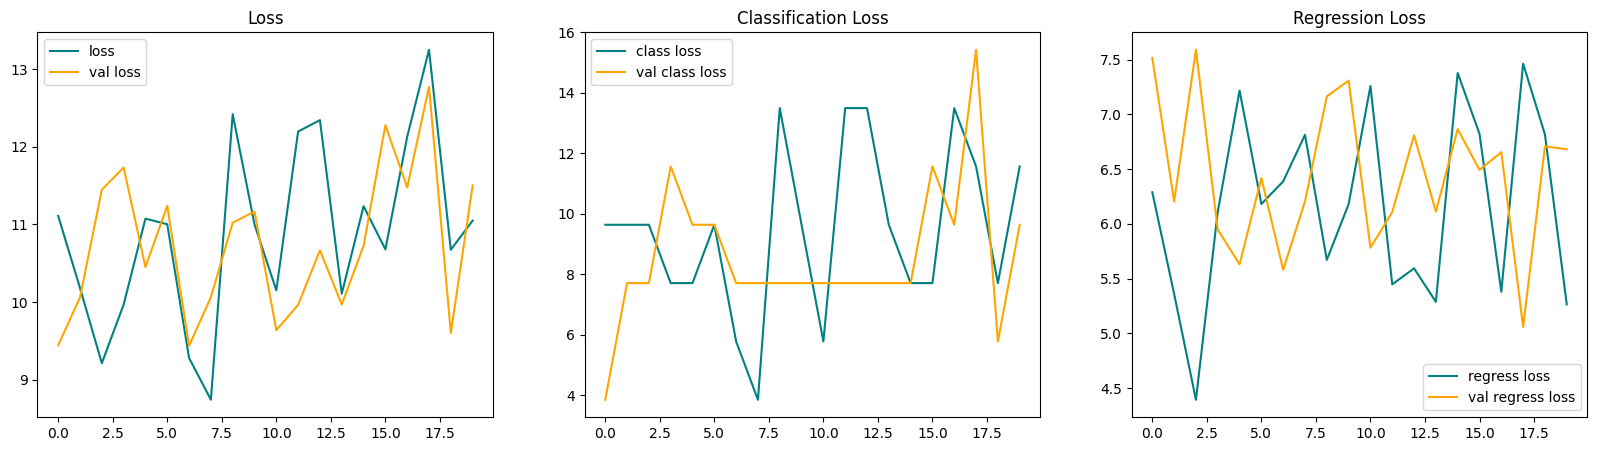

In [65]:
fig, ax = plt.subplots(ncols=3, figsize=(20, 5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make predictions on a test set

In [118]:
test_data = test.as_numpy_iterator()

In [132]:
test_sample = test_data.next()

In [133]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 497ms/step


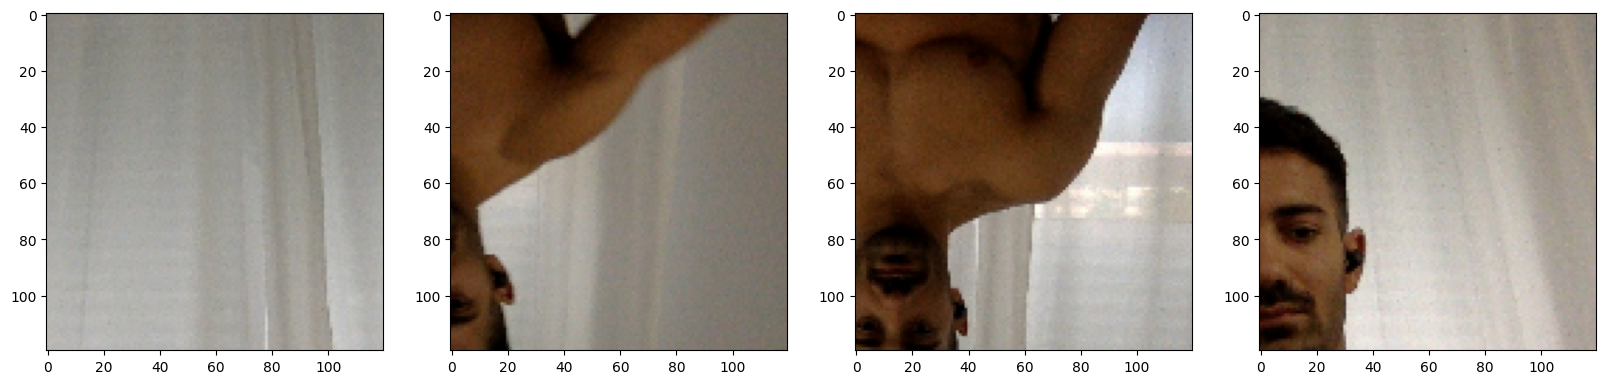

In [134]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))

for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.5:
        cv2.rectangle(sample_image,
                      tuple(np.multiply(sample_coords[:2]), [120, 120]).astype(int),
                      tuple(np.multiply(sample_coords[2:]), [120, 120]).astype(int),\
                      (255, 0, 0), 2
                     )
        
    ax[idx].imshow(sample_image)